# Types of CV Models

## Image Processing Model

1. Input image is read using library like OpenCV.
2. Image is converted into binary format for noise removal.
3. Erosion + Dilation is performed to reduce noise.
4. The walls will be detected by foreground and background segmentation.
5. \# of walls will be detected using contour detection and will store the coordinates for rendering a 3D model.

## 3DPlanNet Model

1. Input image is read
2. Pattern recognition is needed to recognize variety of walls
3. Then apply object detection for information including doors, windows, furniture, materials, dimensions, and text. This means a detection algorithm for each object/feature. Libraries could include TensforFlow object detection API
4. Then node + edge generation is created through the information analyzed from the previous step
5. Object generation is final part that generates the 3D model in the form of 3D mesh objects

## Blender3D

https://github.com/grebtsew/FloorplanToBlender3d?tab=readme-ov-file

Floorplan to blender library called FTBL that converts images into 3D models.

1. Implement Blender3D and import model to CAD (?)
2. Figure out image preprocessing stages
3. Research which models have potential
4. Establish flowchart/pipeline for 2d to 3d generation

# Metrics to Evaluate


1. 2D to 3D Floor plan Modeling using Image Processing and Augmented Reality
- "The accuracy of a 3D model is determined by the accuracy
of the algorithm used to recognize the floor plan image. This
accuracy is calculated by dividing the number of walls that
have been accurately placed in the 3D model by the total
number of walls in the original image. To improve the accuracy
of the model, the algorithm used to recognize the floor plan
image should be fine-tuned to ensure that the walls in the 3D
model are accurately placed in the right locations"

- "We also measured the accuracy improvement when furniture and text were added to the floor plan. We found that the algorithm performed significantly better with these elements included, indicating that they can be used to enhance the accuracy of the algorithm."

- "We found that adding textual or semantic information can
significantly improve the accuracy of recognition, allowing
us to gain further context as to what classifies as a room.
By incorporating this information, we were able to improve
the recognition performance and better distinguish between
different types of rooms."

\\

2. 3DPlanNet: Generating 3D Models from 2D Floor Plan Images
Using Ensemble Methods
- "Naturally, how accurately the information can be extracted greatly affects the performance of the 3D vector models transformation. In the wall pattern recognition step, since recognition was performed excluding the door/window area, we needed to recognize the door/window area in order to increase accuracy."

# Bibliography

1. 2D to 3D Floor plan Modeling using Image
Processing and Augmented Reality (Deshmukh et al.)
2. 3DPlanNet: Generating 3D Models from 2D Floor Plan Images
Using Ensemble Methods (Park and Kim)
3. https://github.com/grebtsew/FloorplanToBlender3d?tab=readme-ov-file
4. Vectorizing Building Blueprints (Song et al.)
5. Towards Robust Object Detection in Floor Plan Images: A Data Augmentation Approach (Mishra et al.)
6. Improved Automatic Analysis of Architectural Floor Plans (Ahmed et al.)

# **Code**

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!pip install PyMuPDF Pillow
!pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 44.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 88.4 MB/s eta 0:00:00


In [3]:
# computer vision
import fitz
import cv2
from google.colab.patches import cv2_imshow

# miscellaneous
import numpy as np
import os
import matplotlib.pyplot as plt

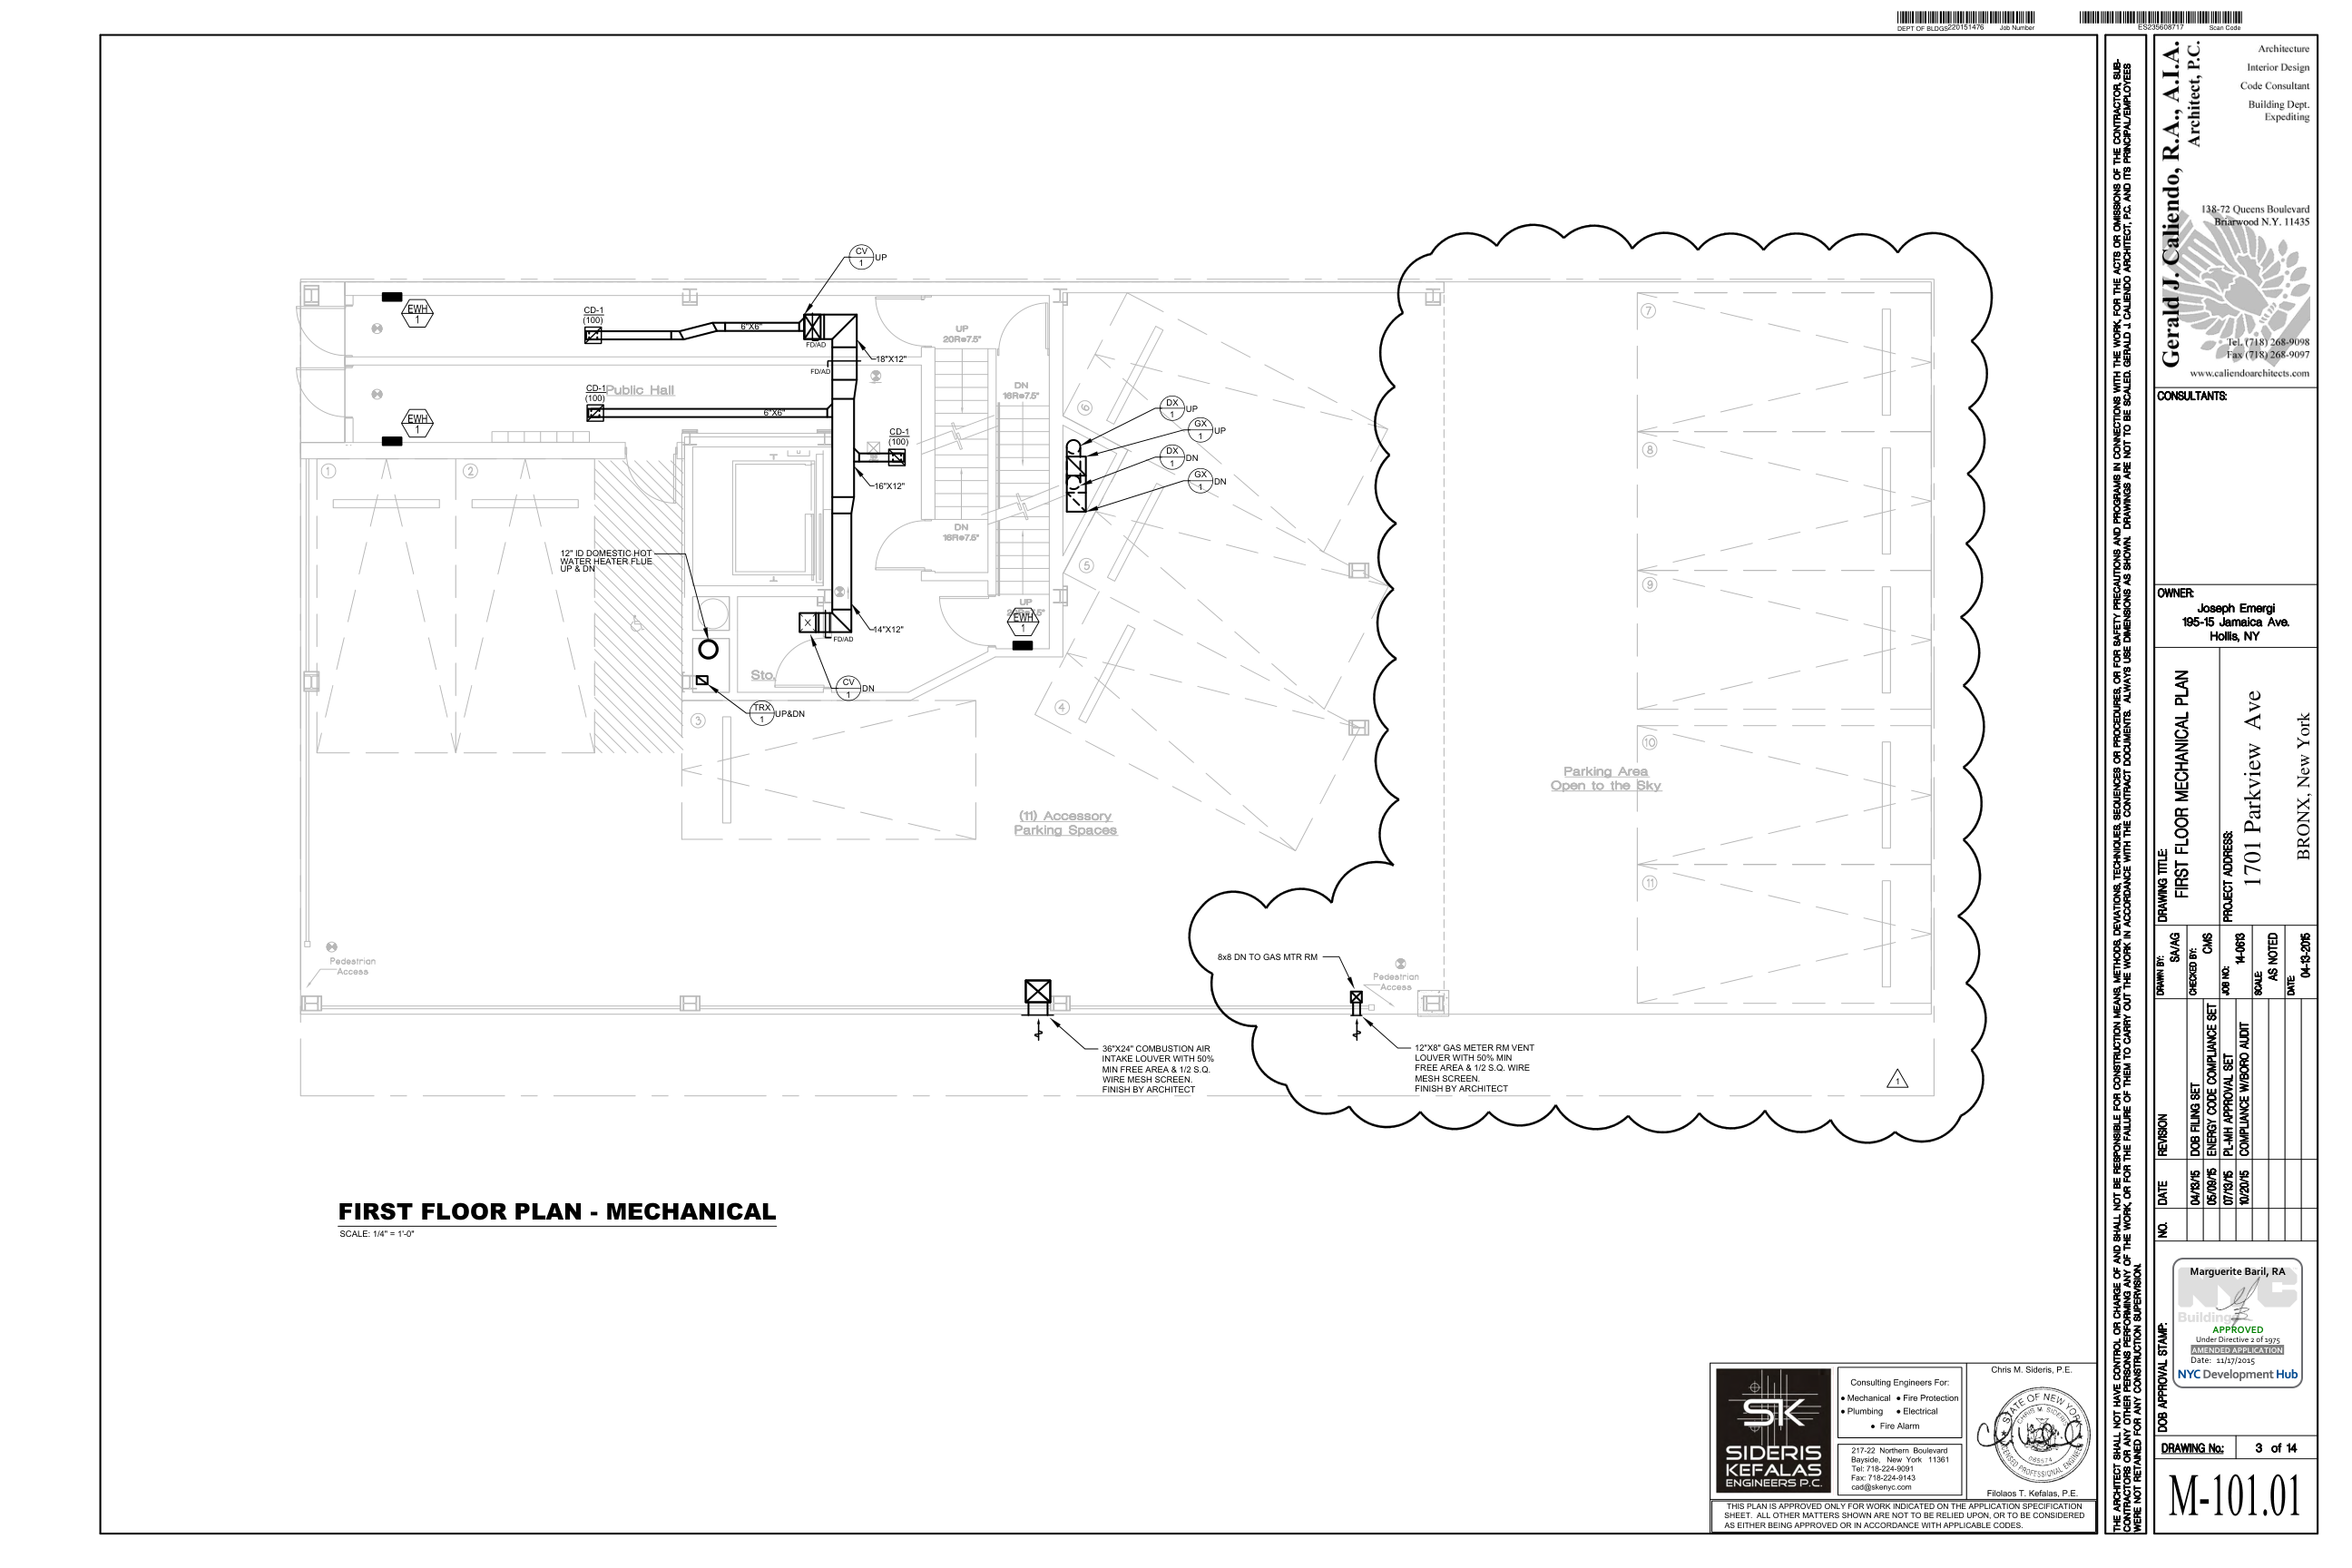

In [22]:
# Load the image using OpenCV
image_path = '/content/drive/MyDrive/*Datasets/Parkview Data Images/page_49.png'
img = cv2.imread(image_path)

# Display the image using cv2_imshow (for Google Colab)
cv2_imshow(img)

We want to be able to **(1) isolate the floor plan layout via *edge detection*** and  **(2) classify the floor plan type via *template matching***

# Extracting Floor Plan Type

1. Architectural (A)
2. Mechanical (M)
3. Plumbing (P)
4. Structural (S)

## Cropping Image based on right corner detection

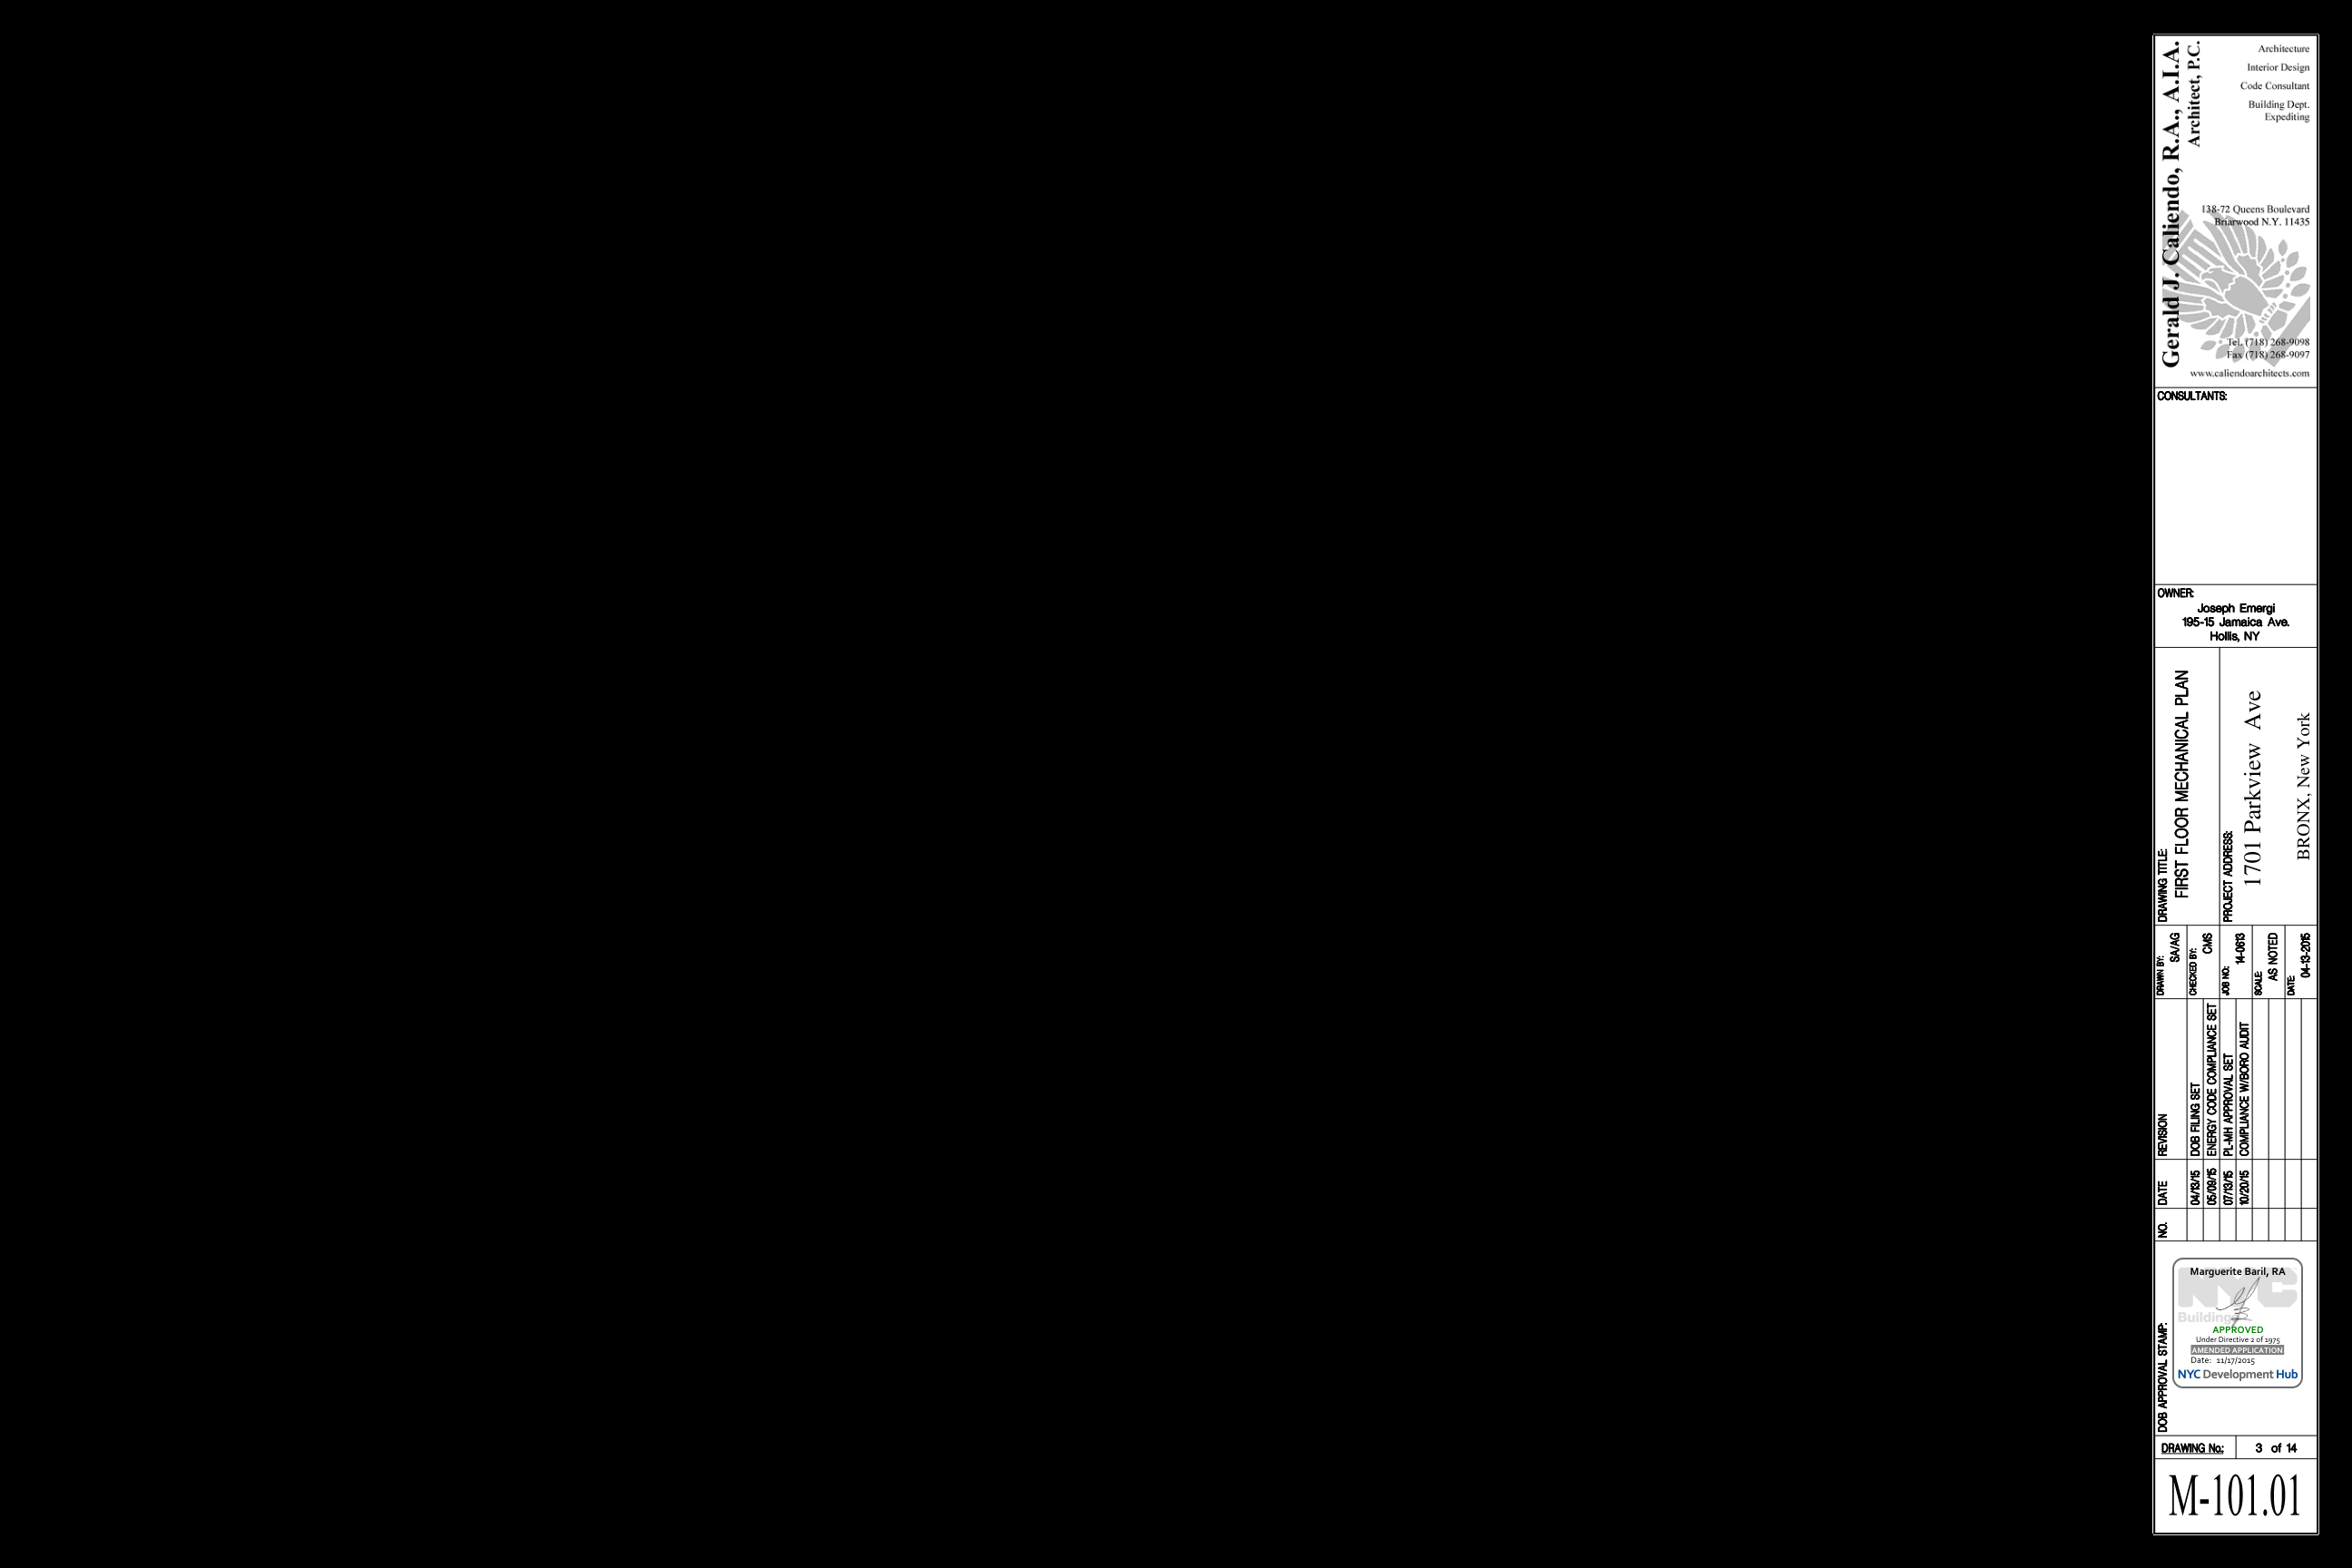

In [23]:
def extract_contour_by_index(img, index=0):
    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply a Gaussian blur to smooth out the edges
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Apply Canny Edge Detector
    edges = cv2.Canny(blurred, 50, 150)

    # Find contours
    contours, hierarchy = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Sort contours based on area
    sorted_contours = sorted(contours, key=cv2.contourArea, reverse=True)

    # Check if there are enough contours
    if len(sorted_contours) > index:
        selected_contour = sorted_contours[index]

        # Create an empty mask
        mask = np.zeros_like(gray)

        # Draw the selected contour on the mask
        cv2.drawContours(mask, [selected_contour], -1, (255), thickness=cv2.FILLED)

        # Create an output image using the mask
        output = cv2.bitwise_and(img, img, mask=mask)
        return output
    else:
        print("Not enough contours found to select the specified index.")
        return img

# Example usage to extract the second largest contour:
sidebar_image = extract_contour_by_index(img, index=1)
cv2_imshow(sidebar_image)

This following function is just an experiment to test out template matching for floorplan classification. This is further implemented in the next slide when iterating through each image in the folder.

Template matched with confidence: 0.9999996423721313


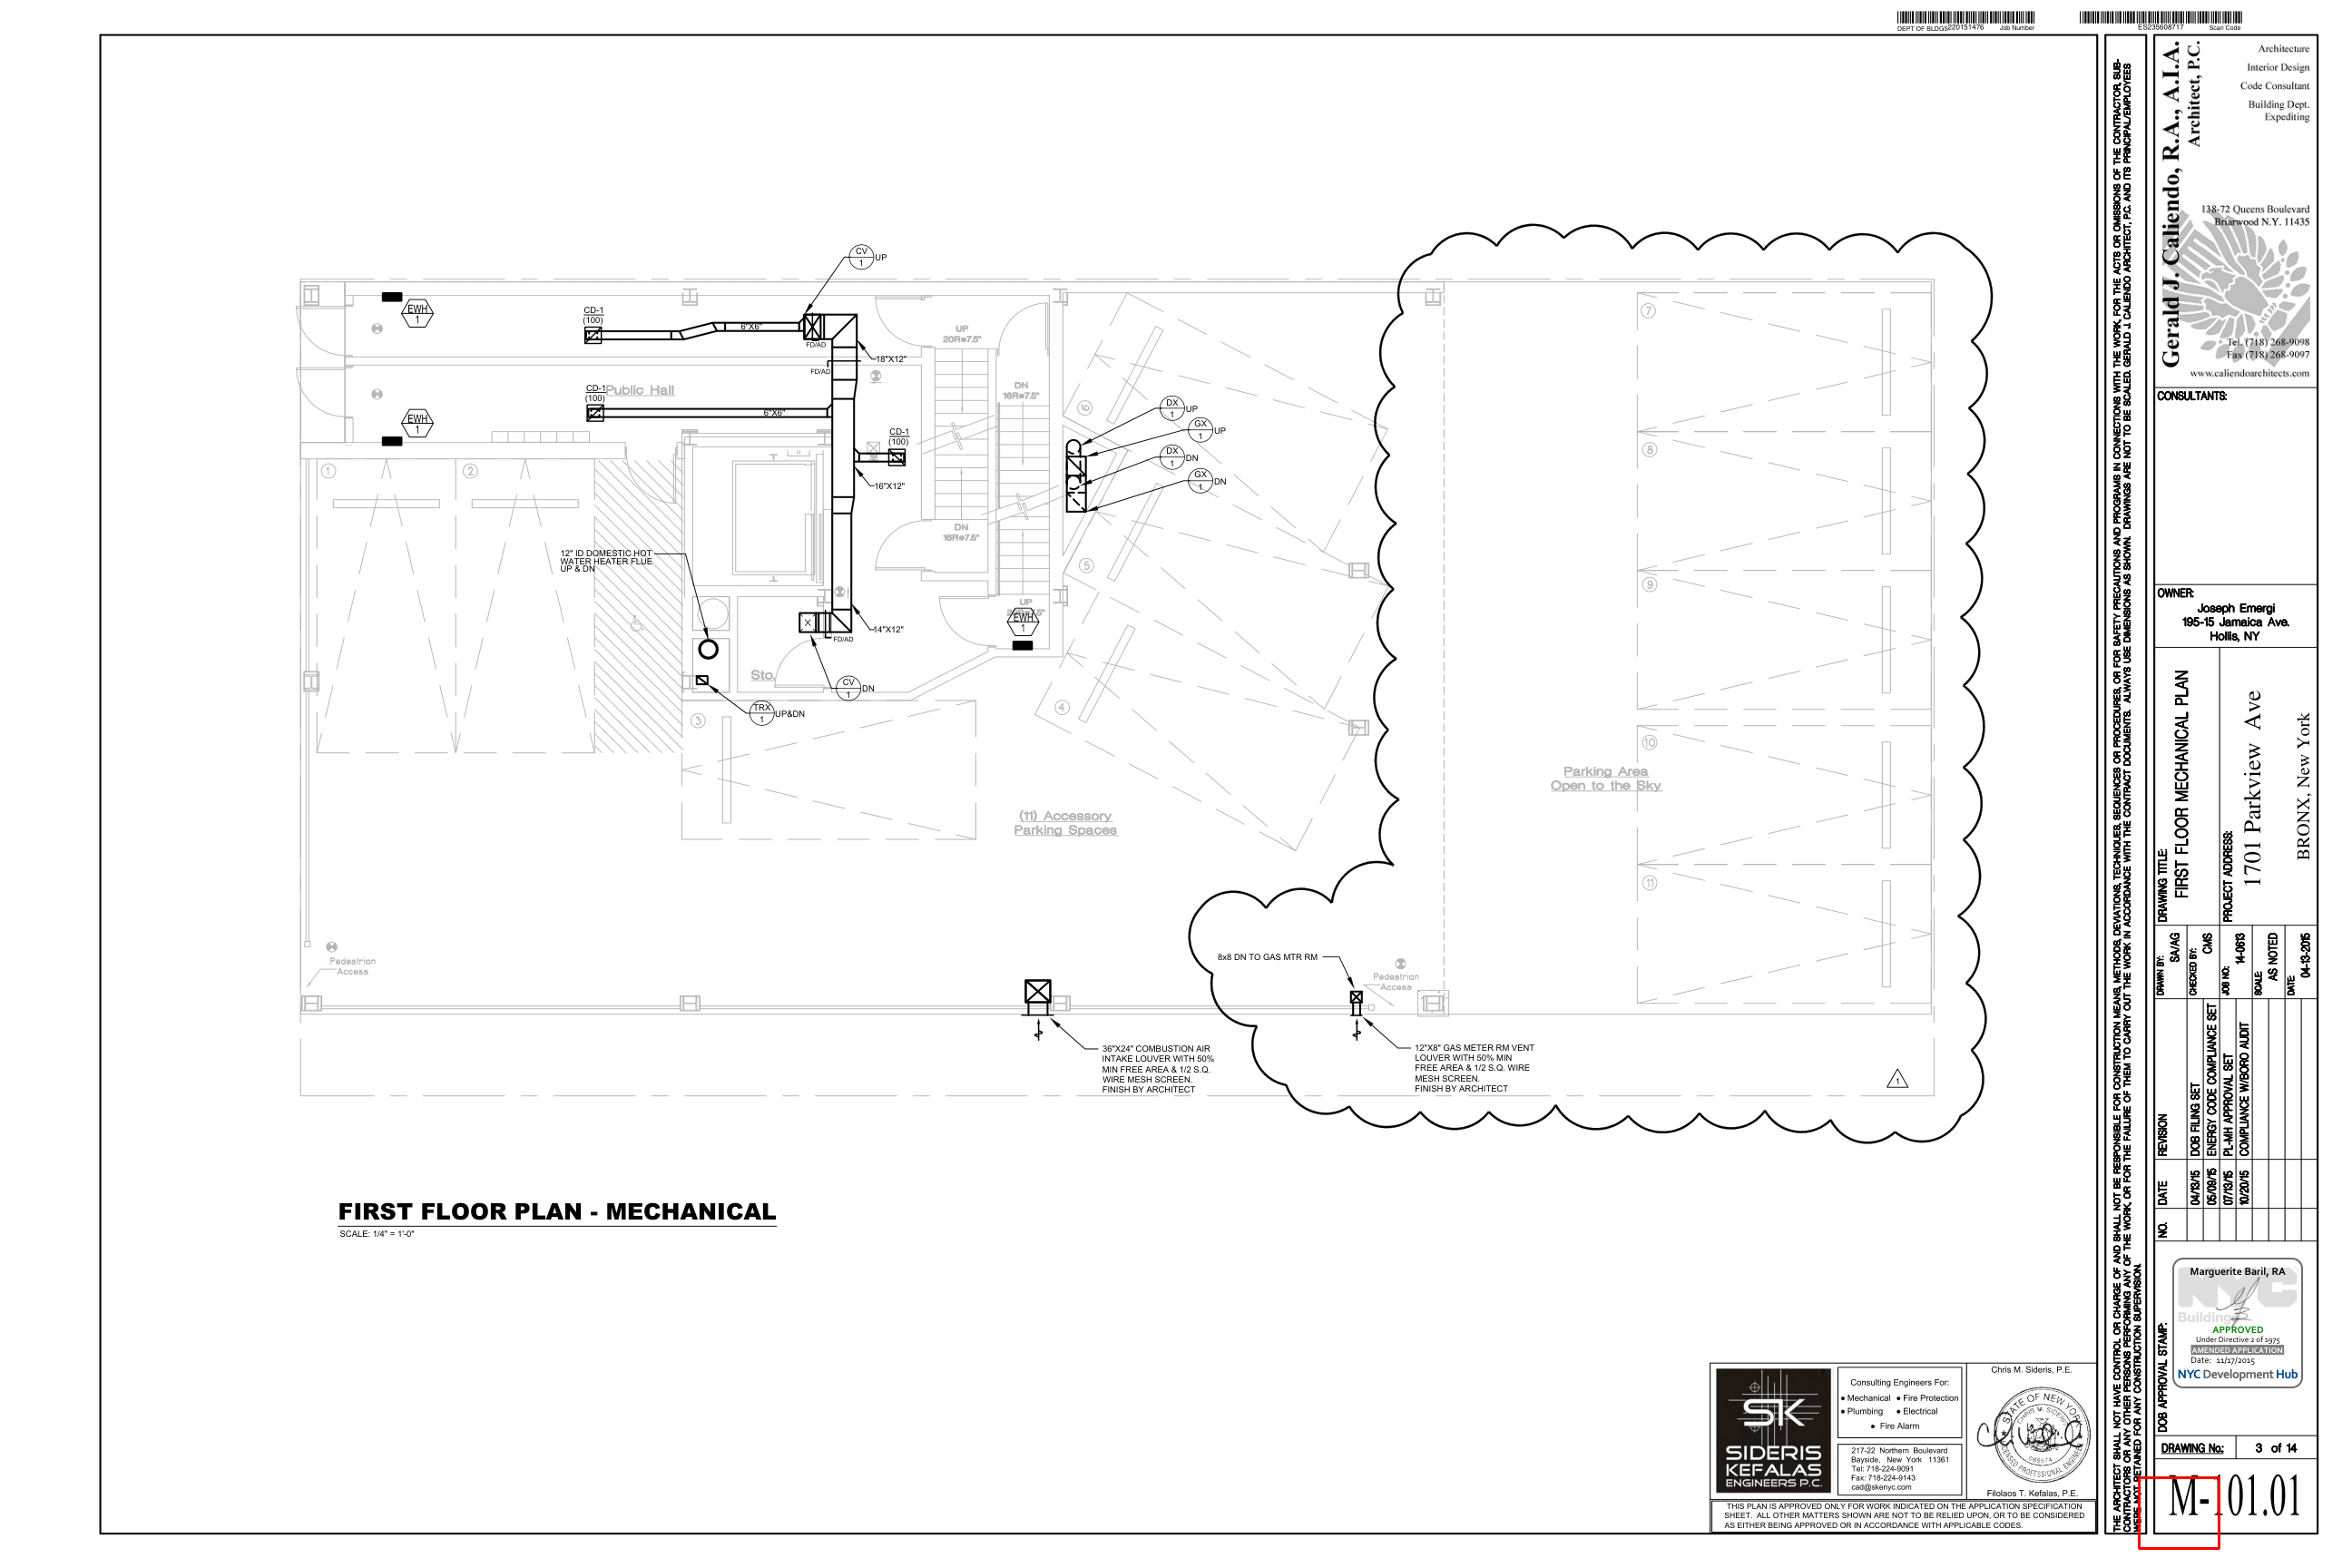

In [24]:
def floorplan_matching(full_image, sidebar_image, template_path='/content/Mech-general-label.png'):
    # Convert the sidebar image to grayscale
    gray_sidebar = cv2.cvtColor(sidebar_image, cv2.COLOR_BGR2GRAY)

    # Load the template image
    template = cv2.imread(template_path, 0)
    t_w, t_h = template.shape[::-1]  # Original width and height of the template

    # Apply template matching on the sidebar grayscale image
    res = cv2.matchTemplate(gray_sidebar, template, cv2.TM_CCOEFF_NORMED)
    _, max_val, max_loc, _ = cv2.minMaxLoc(res)

    # Check if the matching score is above a threshold
    threshold = 0.85
    if max_val > threshold:
        # Calculate the rectangle's top-left and bottom-right corners based on the match location in the sidebar image
        top_left = max_loc
        bottom_right = (top_left[0] + t_w, top_left[1] + t_h)

        # Draw the rectangle on the full image
        # Adjust these coordinates if the sidebar is at a specific offset within the full image
        cv2.rectangle(full_image, top_left, bottom_right, (0, 0, 255), 2)
        print(f"Template matched with confidence: {max_val}")

    # Return the processed full image with the template match highlighted
    return full_image

labeled_image = floorplan_matching(img, sidebar_image)
cv2_imshow(labeled_image)

Seeing that template matching works well with the cropped images, we can now implement the predefined custom function into the automated algorithm to classify them.

1. *delete_files_in_folder(folder_path)*: deletes all the files in the specified folder to clear the contents before adding newly labeled images.


2. *process_image(template_image_path)*: performs image processing on the image, including CLAHE for contrast enhancement and Gaussian blur for noise reduction to improve template matching accuracy.


3. *perform_matching()*: compares the processed image against multiple templates using template matching at different scales, returning the label with the highest matching score.


4. *extract_floorplan_label()*: loads images and templates, processes and matches each image to the most fitting template, and categorizes images into labeled folders based on the match or into an 'Uncategorized' folder if no match meets the threshold.

In [25]:
import shutil

# deletes all the files in the specified folder to clear
# before adding newly labeled images
def delete_files_in_folder(folder):
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
                print(f"{filename} has been deleted")
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print(f'Failed to delete {file_path}. Reason: {e}')



# perform image processing using CLAHE for contrast enhancement and
# gaussian blur for noise reduction to improve accuracy of template matching
def process_image(image):
    # debug if image is not read properly
    if image is None:
        print(f"Failed to load image")
        return None

    # contrast limited adaptive histogram equalization and gaussian blur
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    image = clahe.apply(image)
    image = cv2.GaussianBlur(image, (3, 3), 0)

    return image

    # contrast limited adaptive histogram equalization and gaussian blur
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    image = clahe.apply(image)
    image = cv2.GaussianBlur(image, (3, 3), 0)

    return image



# compares the input image against the various templates
def perform_matching(image, templates):
    # initialize
    best_label = None
    best_score = 0

    # loop through the templates and determine scales needed for best performance
    for label, template, (w, h) in templates:
        scales = [0.5, 0.75, 1, 1.25, 1.5]
        local_best_score = 0  # Track the best score for this specific template

        # for each scale, resize the template and perform matching
        for scale in scales:
            resized_template = cv2.resize(template, None, fx=scale, fy=scale)
            res = cv2.matchTemplate(image, resized_template, cv2.TM_CCOEFF_NORMED)
            _, max_val, _, _ = cv2.minMaxLoc(res)

            if max_val > local_best_score:
                local_best_score = max_val

        if local_best_score > best_score:
            best_score = local_best_score
            best_label = label

    return best_label, best_score



# loads images and templates, processes and matches each image to the most fitting template,
# and categorizes images into labeled folders based on the match or into an uncategorized folder
# if no match meets the threshold
def extract_floorplan_label(base_folder_path, templates, output_folder_path, uncategorized_folder):
    # ----------------------------------------------
    # this section accesses and deletes the current images
    # in the folder in order to add the labeled images
    for label in templates.keys():
        label_folder = os.path.join(output_folder_path, label)
        if os.path.exists(label_folder):
            delete_files_in_folder(label_folder)
        else:
            os.makedirs(label_folder)

    if os.path.exists(uncategorized_folder):
        delete_files_in_folder(uncategorized_folder)
    else:
        os.makedirs(uncategorized_folder)
    # ----------------------------------------------

    # To store scores for each label
    score_tracker = {label: [] for label in templates.keys()}

    # Compile list of templates that will be used for matching
    prepared_templates = []
    for label, template_path in templates.items():
        template_image = cv2.imread(template_path, 0)  # Read as grayscale
        processed_template = process_image(template_image)
        if processed_template is not None:
            prepared_templates.append((label, processed_template, processed_template.shape[::-1]))
    # ----------------------------------------------


    # Loop through each image in the folder to process and label
    for filename in os.listdir(base_folder_path):
        file_path = os.path.join(base_folder_path, filename)
        img = cv2.imread(file_path)

        # Debug if image could not be read
        if img is None:
            print(f"Failed to load image: {file_path}")
            continue

        # Initialize categorized to False for each image
        categorized = False

        # Convert the image to grayscale before processing
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        gray_img = process_image(gray_img)

        # Perform template matching
        best_label, best_score = perform_matching(gray_img, prepared_templates)

        # Adjusting the threshold parameter for matching to improve accuracy
        threshold = 0.85
        if best_score >= threshold:
            output_path = os.path.join(output_folder_path, best_label, filename)
            print(f"Categorizing as {best_label} with score {best_score}, saving to: {output_path}")
            cv2.imwrite(output_path, img)
            categorized = True  # Mark the image as categorized

        # If the image was not categorized, save it to the 'Uncategorized' folder
        if not categorized:
            uncategorized_path = os.path.join(uncategorized_folder, filename)
            print(f"Categorizing as Uncategorized: {uncategorized_path}")
            cv2.imwrite(uncategorized_path, img)

    # Calculate and return the average score for each label
    average_scores = {label: (sum(scores) / len(scores)) if scores else 0 for label, scores in score_tracker.items()}
    return average_scores


In [26]:
# Initiate folder paths and templates
base_folder_path = '/content/drive/MyDrive/*Datasets/Parkview Data Images/'
templates = {
    'Mechanical': '/content/Mech-general-label.png',
    'Plumbing': '/content/Plumb-general-label.png',
    'Architectural': '/content/Arch-general-label.png',
    'Structural': '/content/Struct-label.png',
}

output_folder_path = '/content/drive/MyDrive/*Datasets/Nearabl_Floorplan_labels/'
uncategorized_folder = '/content/drive/MyDrive/*Datasets/Nearabl_Floorplan_labels/Uncategorized/'

#average_scores = extract_floorplan_label(base_folder_path, templates, output_folder_path, uncategorized_folder)

# Isolating Floor Plan Layout via Edge Detection

Since the layouts of all the images for this given data folder are located in nearly the same region on every page, we could exploit this for now to crop the dimensions of the image and focus on the layout. We will need to revisit this later down the timeline to generalize it.

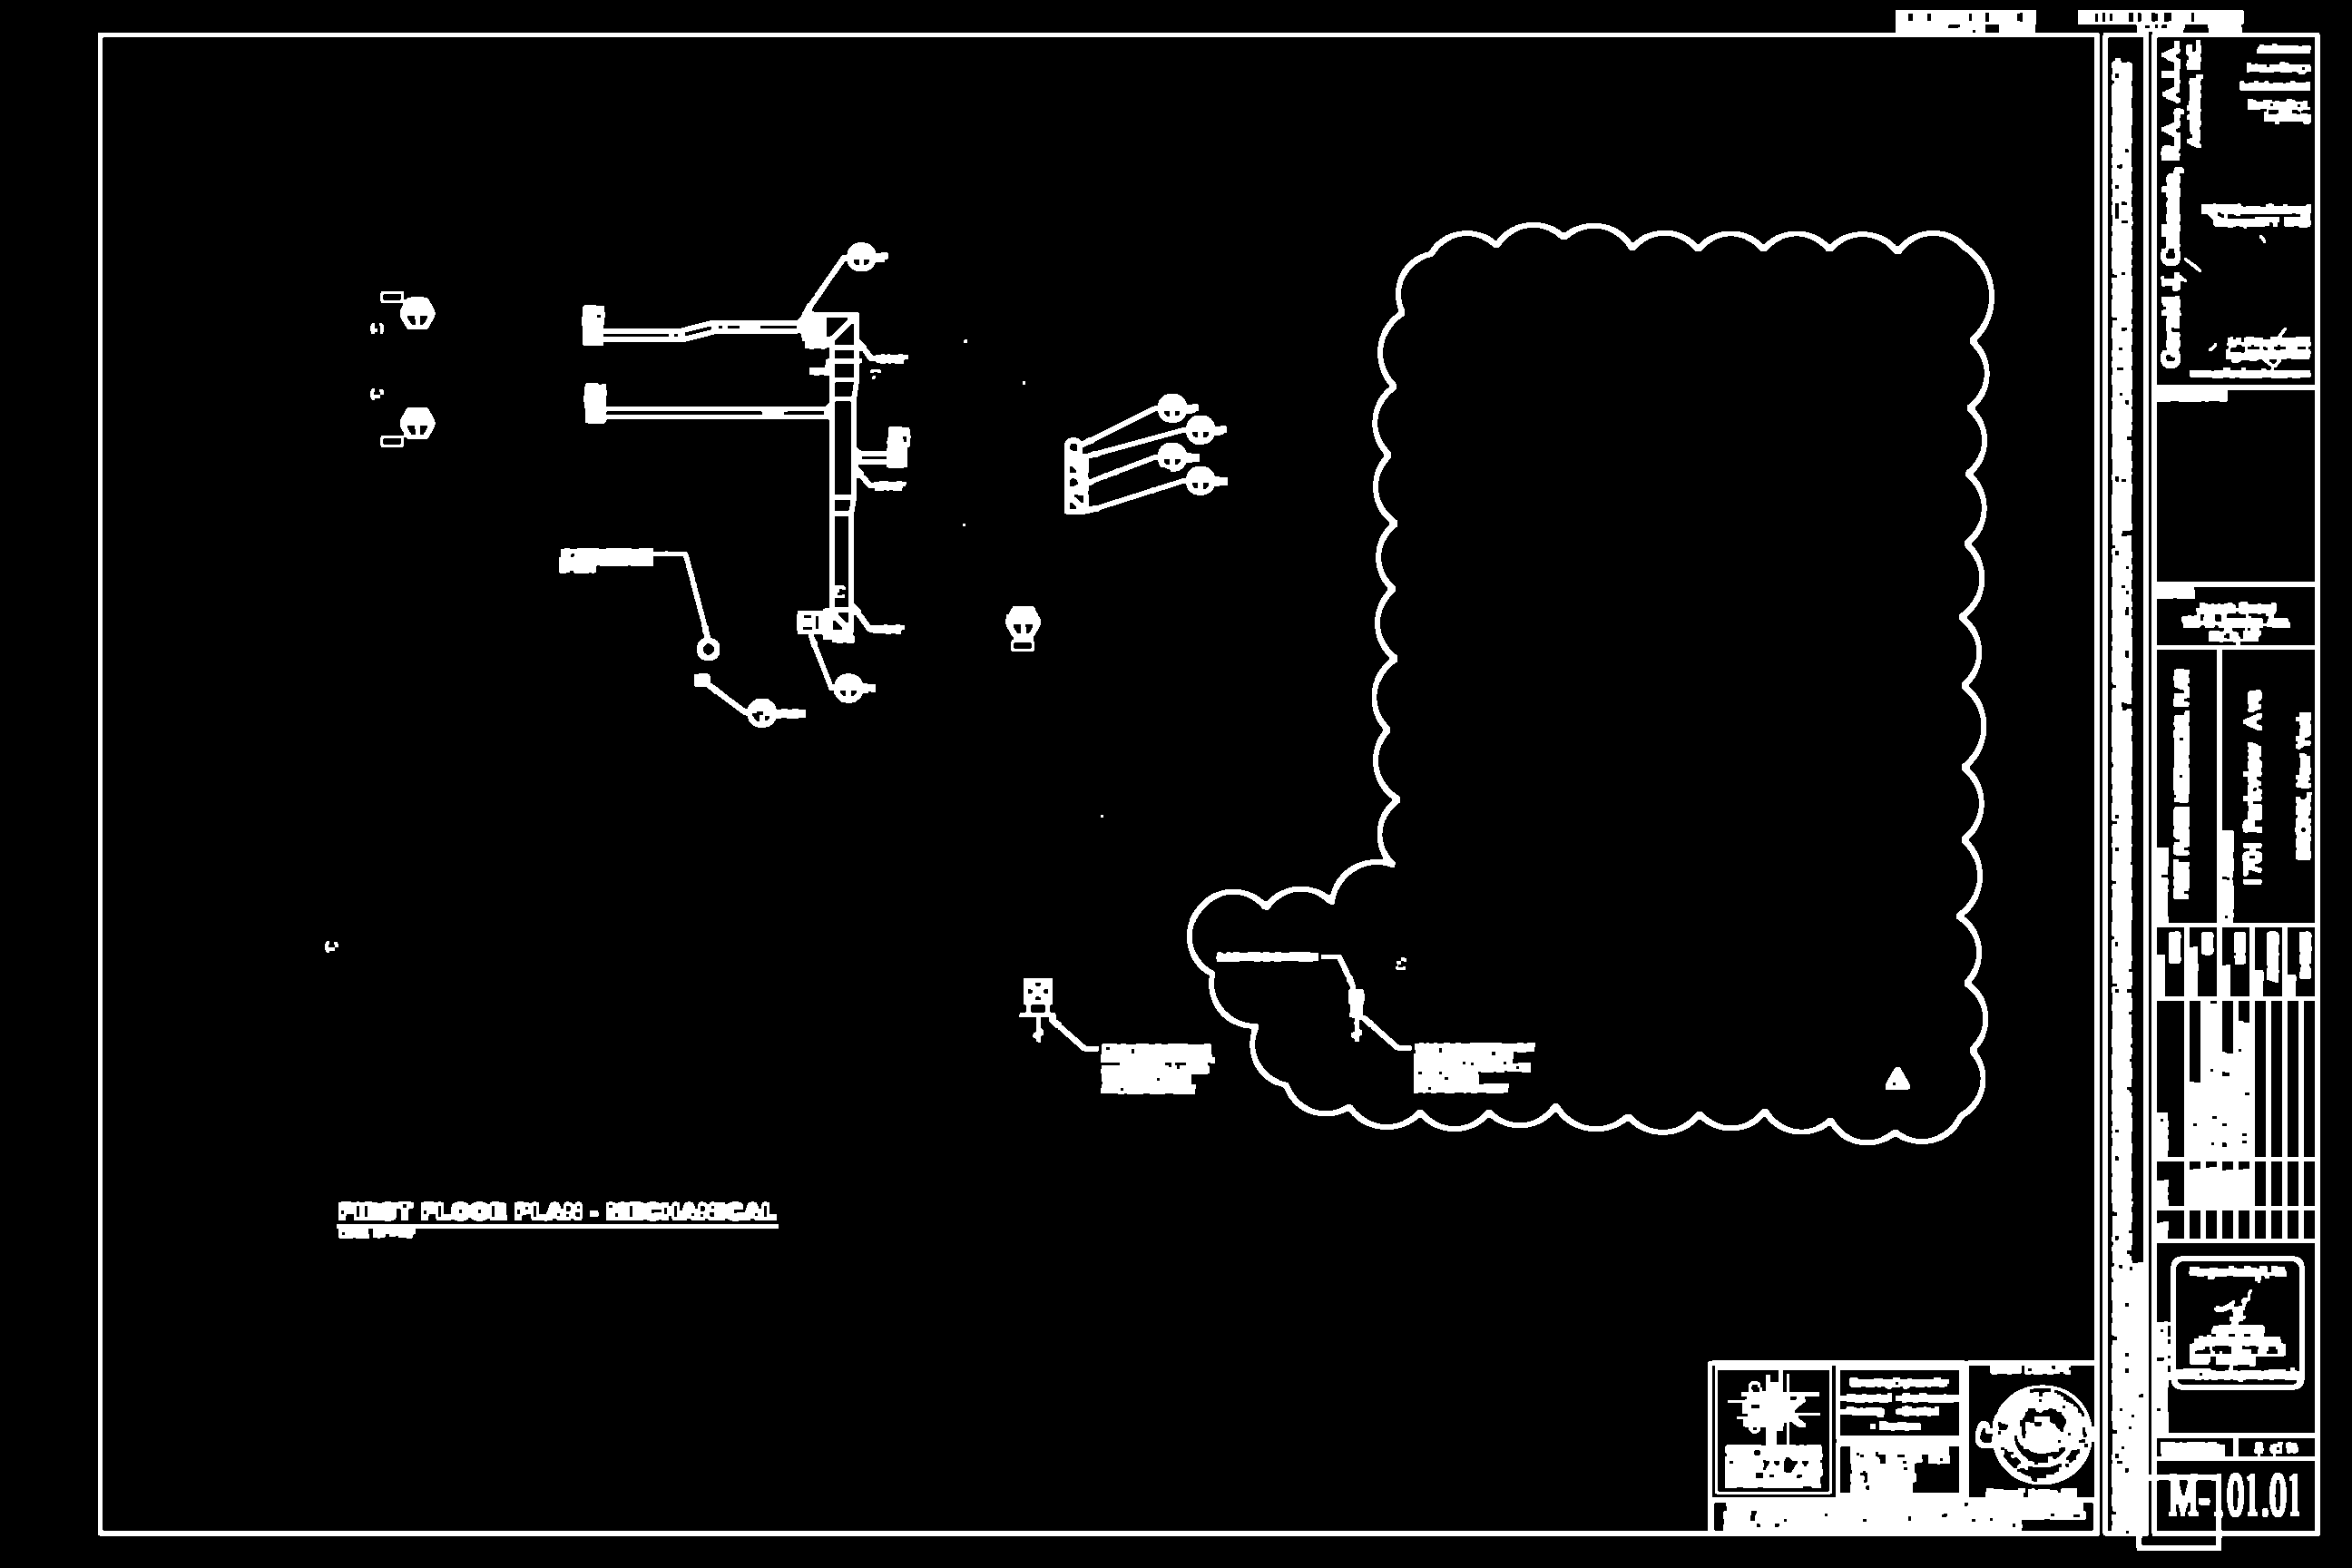

In [27]:
# Apply gaussian blur to reduce noise and
# canny edge to detect edges improve accuracy of edge recognition
blurred = cv2.GaussianBlur(img, (3, 3), 0)
edges = cv2.Canny(blurred, 250, 300)

# dilation emphasizes edges, which can help
# to connect incomplete sections of the walls
kernel = np.ones((3,3), np.uint8)
dilated = cv2.dilate(edges, kernel, iterations=1)
closed = cv2.morphologyEx(dilated, cv2.MORPH_CLOSE, kernel)

cv2_imshow(closed)

I want to automate this process to all images now in their own respective folders.

The code below identifies the edges of the layout, then performs contour detection and isolates everything outside the largest contour (outer walls)

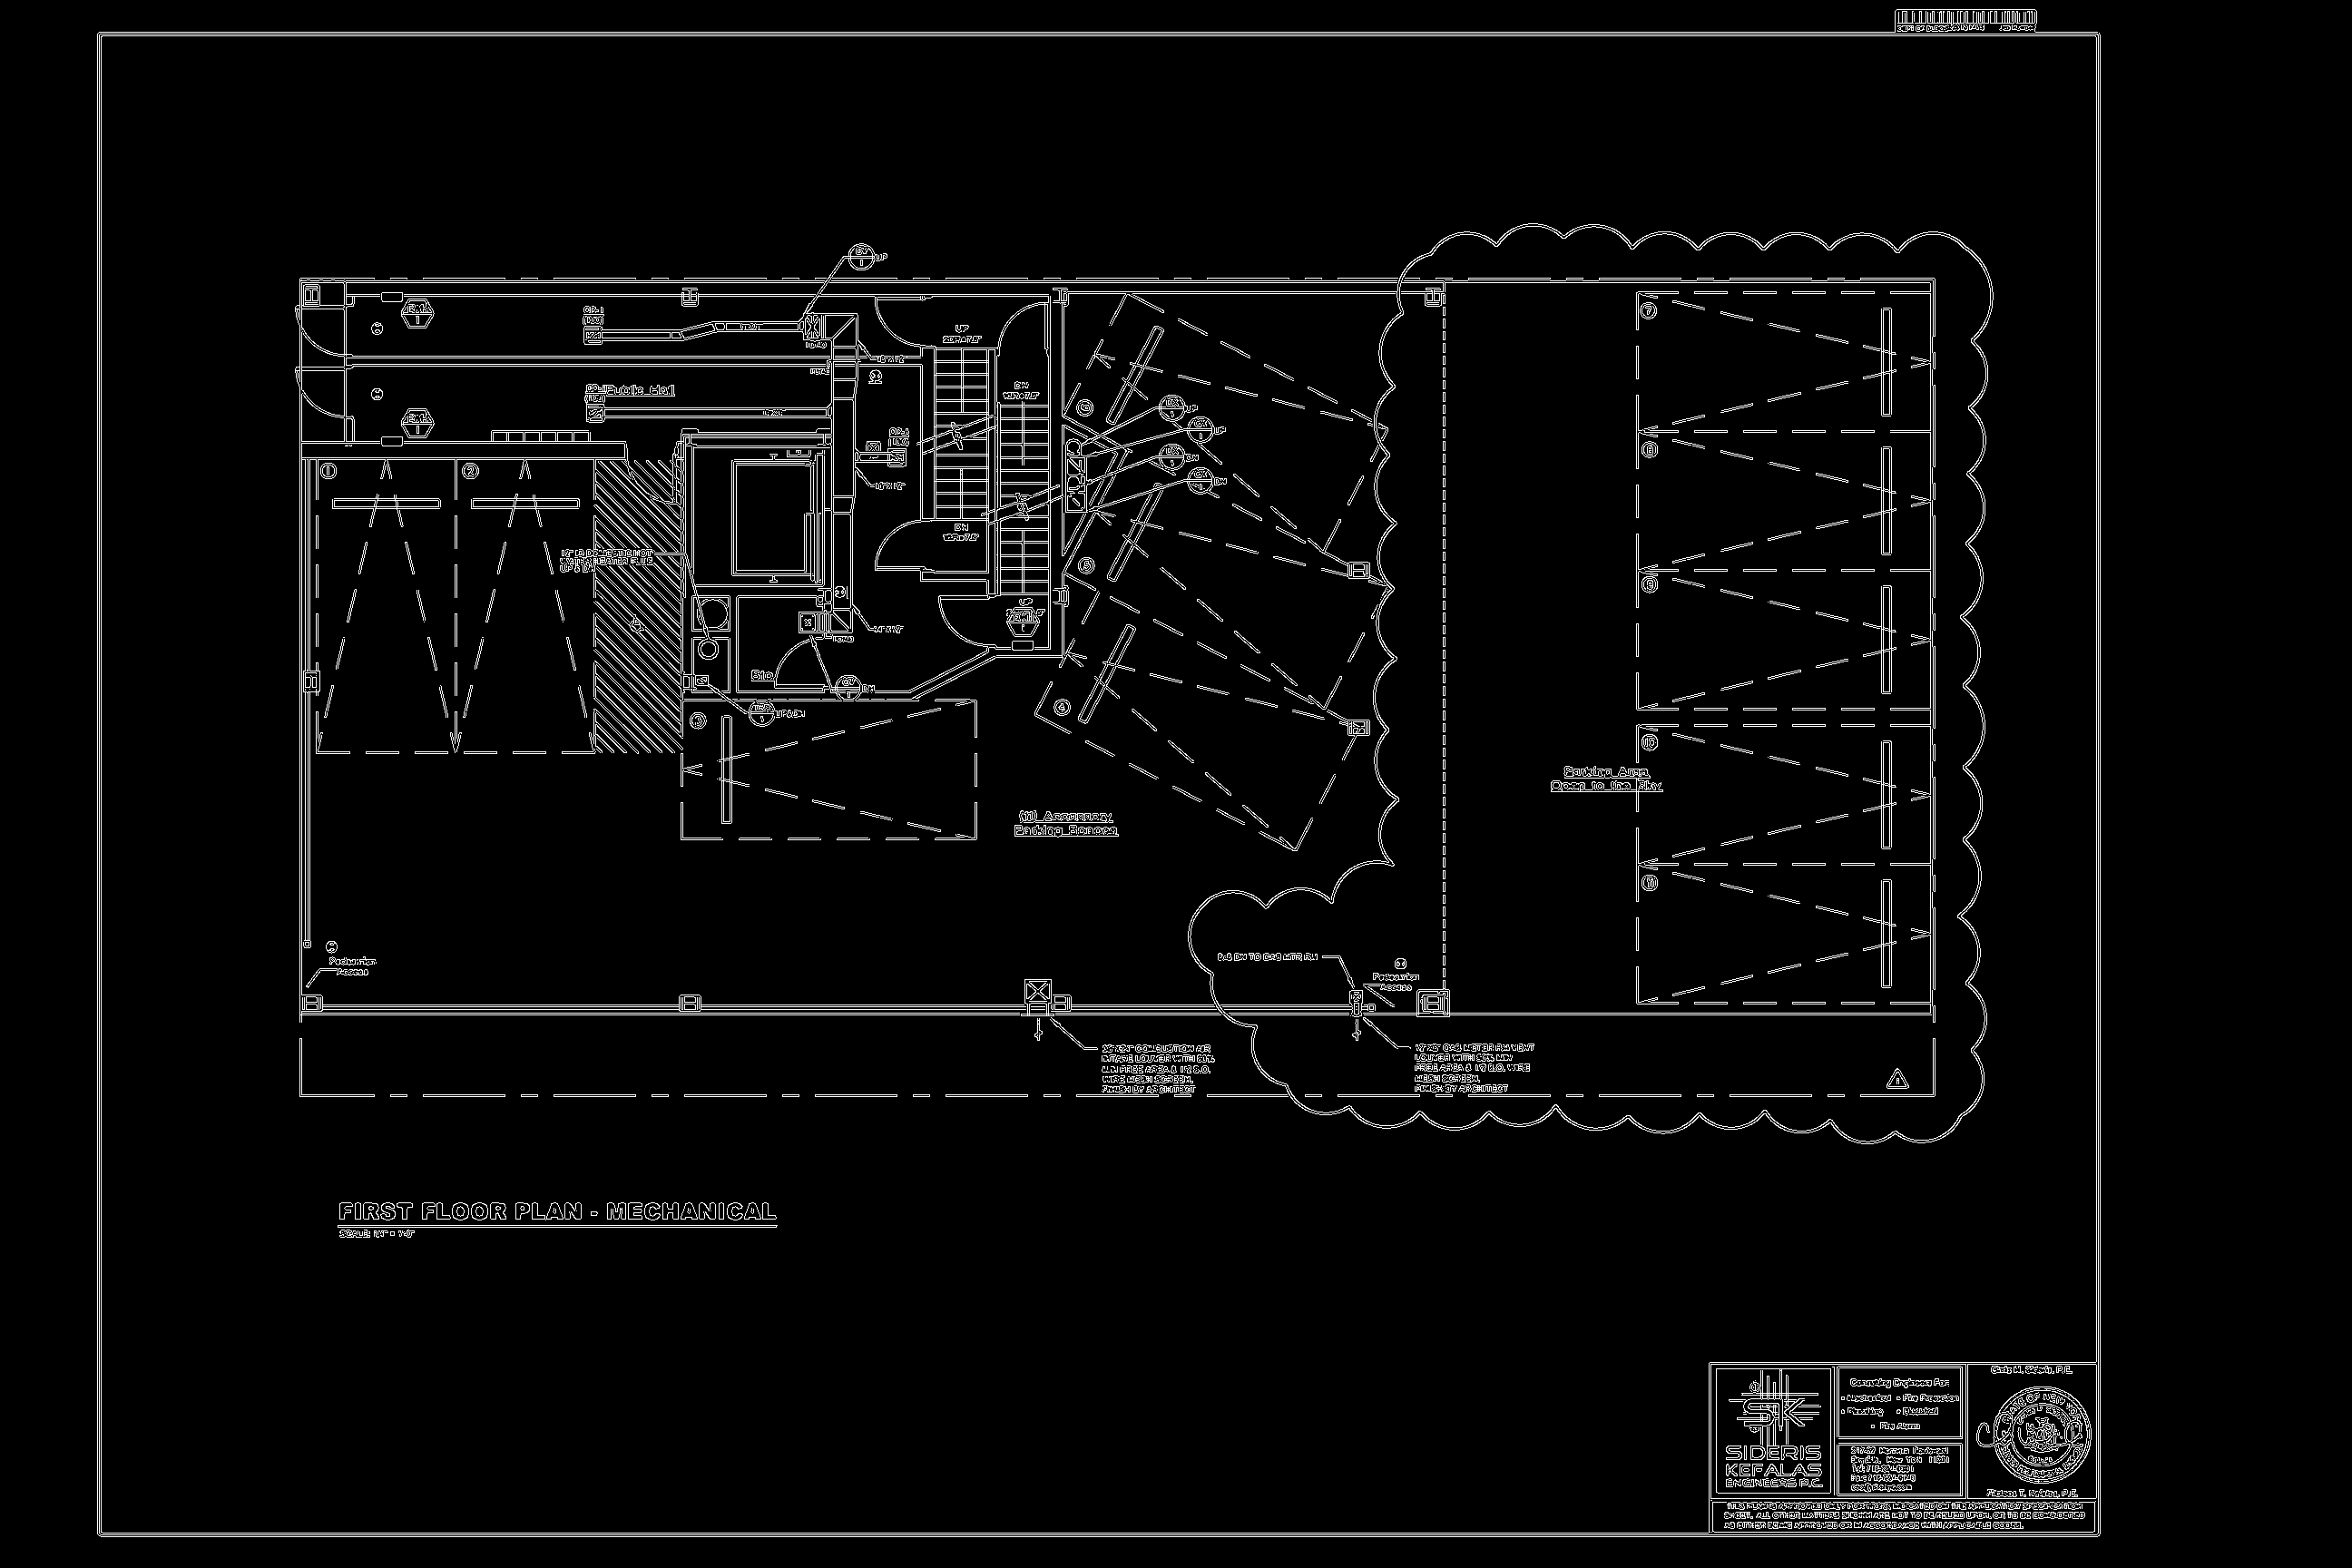

In [28]:
# detects the contours from the enhanced edges from the previous operation
contours, hierarchy = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=cv2.contourArea, reverse=True)
outer_contour = contours[0]  # Largest contour

# a mask is created to isolate the largest contour with the same size as the processed image
mask = np.zeros(img.shape[:2], dtype=np.uint8)
cv2.drawContours(mask, [outer_contour], -1, (255), thickness=cv2.FILLED)

# uses the mask to perform the isolation of removing everything outside the contour area, then reapplies Canny's operator to focus again on the edges
masked_image = cv2.bitwise_and(img, img, mask=mask)
masked_edges = cv2.Canny(masked_image, 50, 100)

cv2_imshow(masked_edges)

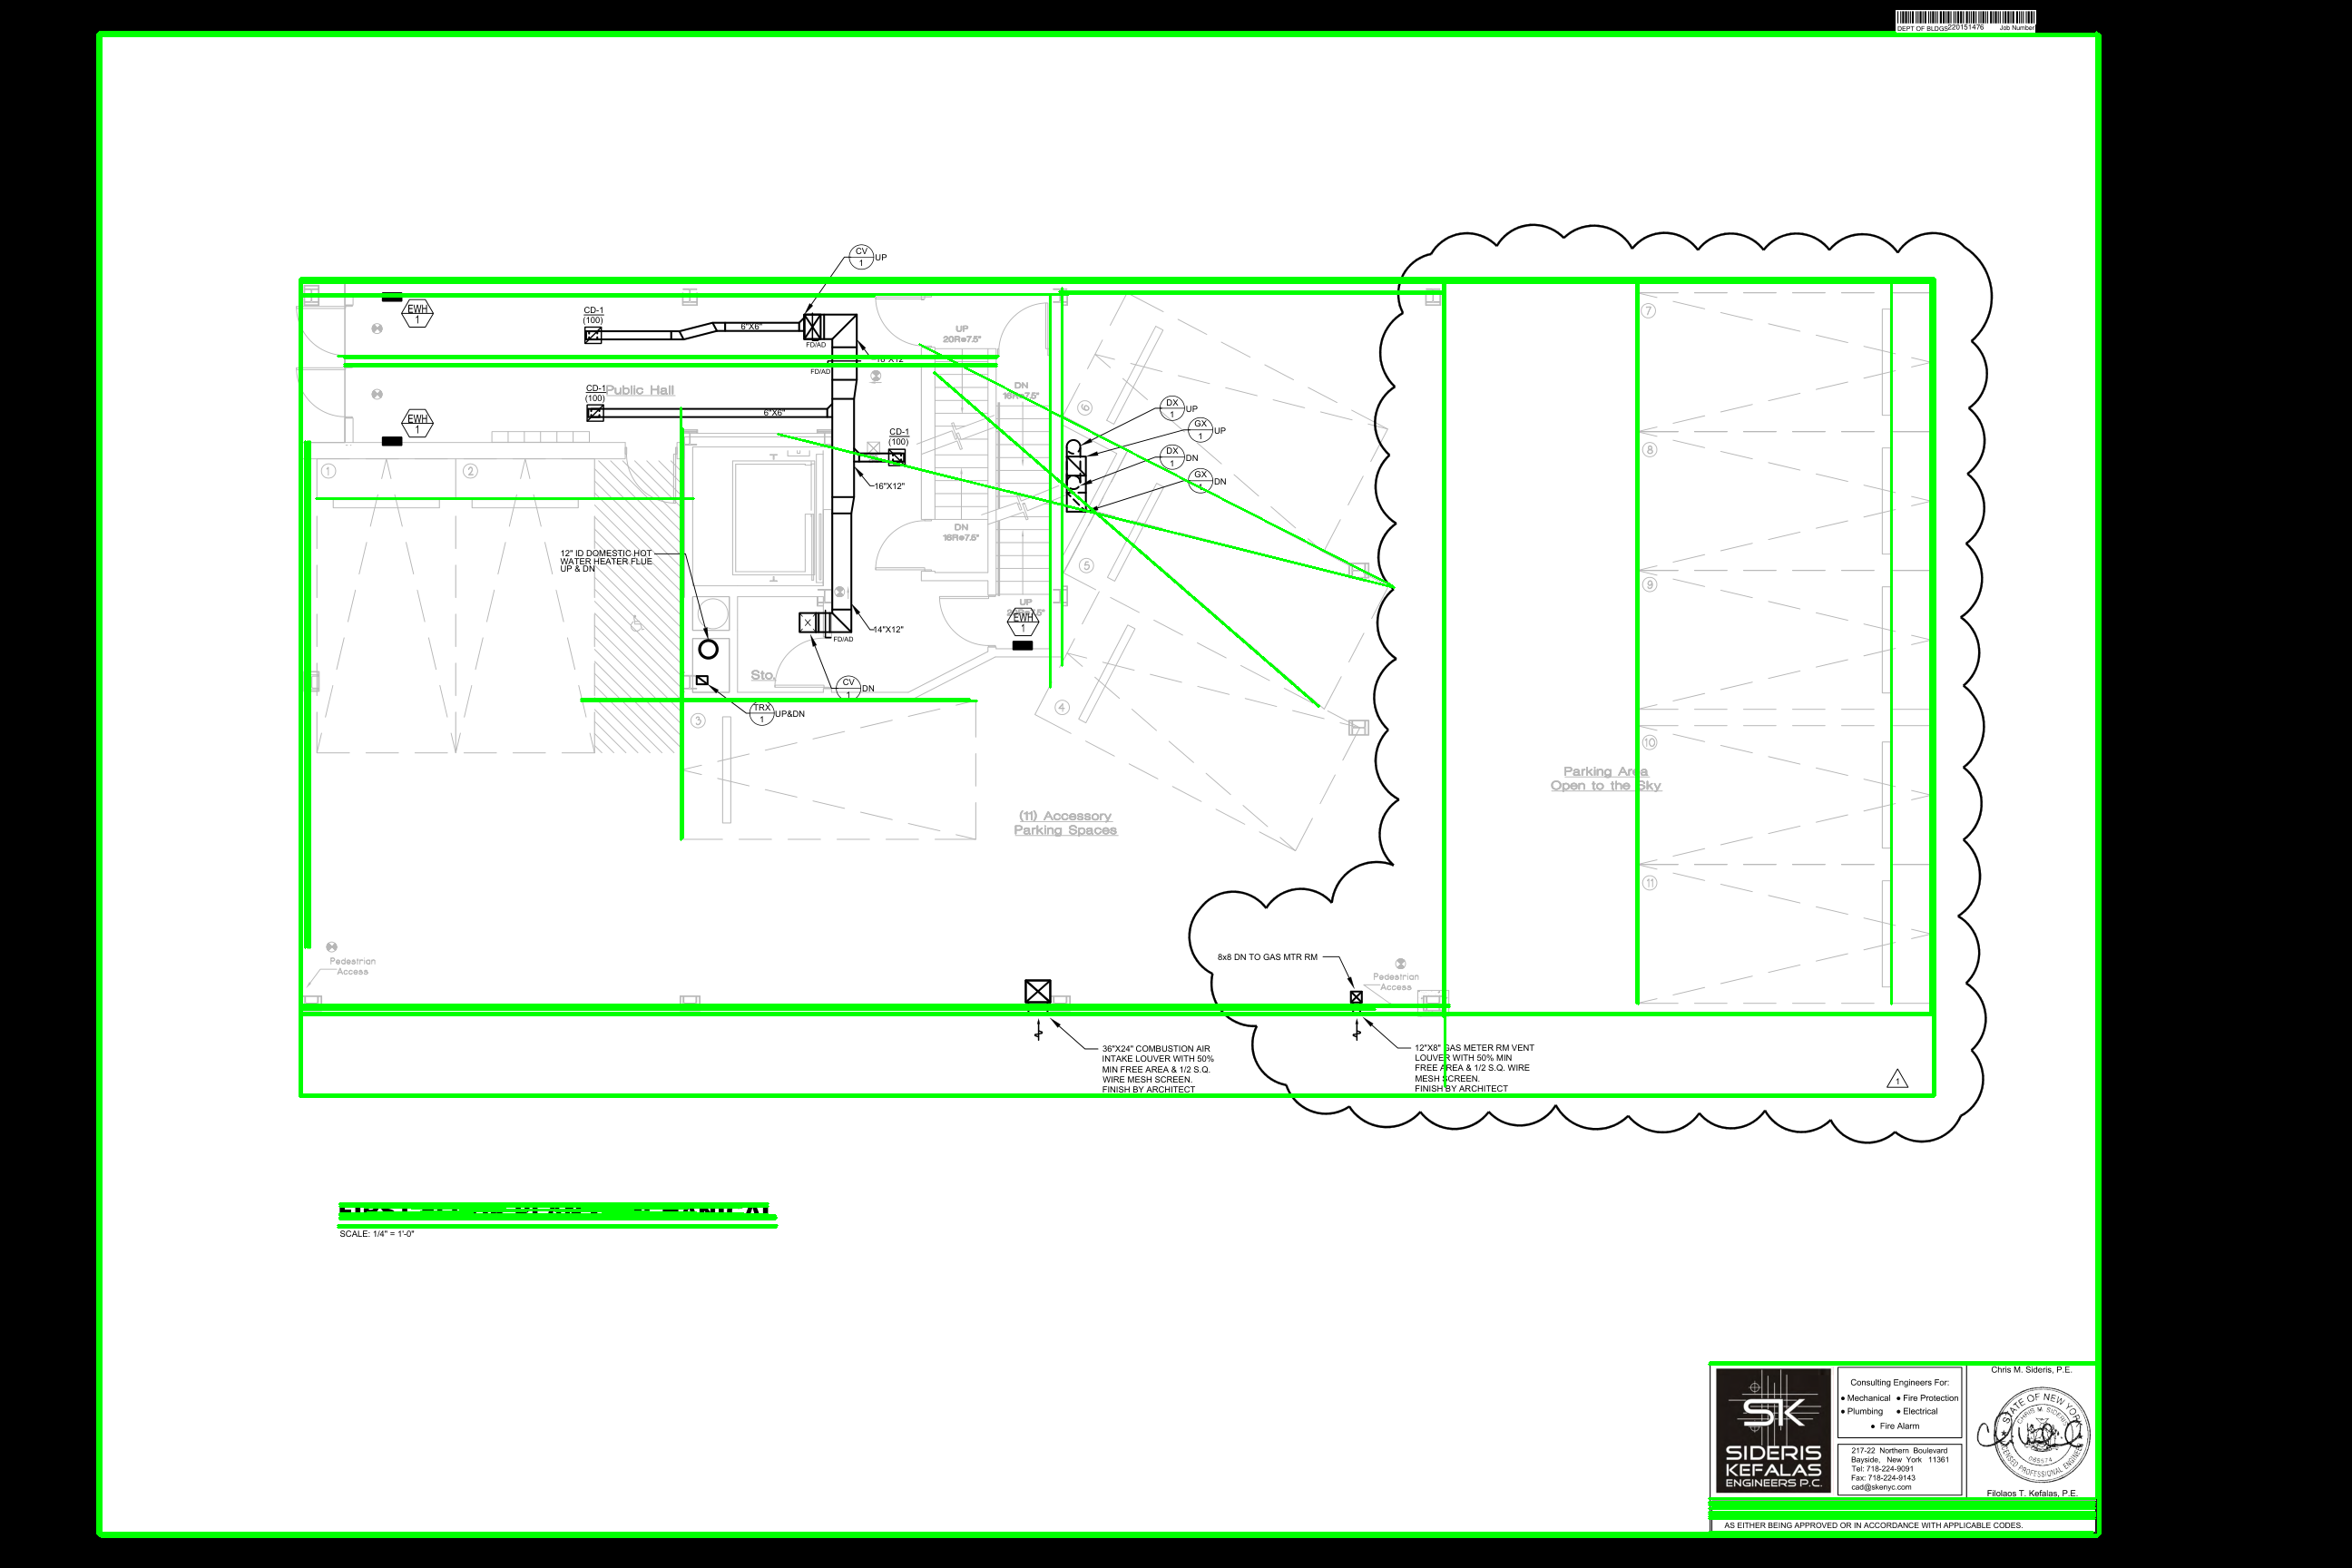

In [29]:
# Assuming masked_edges and other preprocessing have been correctly done:
lines = cv2.HoughLinesP(masked_edges, 1, np.pi / 180, threshold=70, minLineLength=400, maxLineGap=30)

output_image = masked_image.copy()

# Draw lines on the image
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(output_image, (x1, y1), (x2, y2), (0, 255, 0), 2)

cv2_imshow(output_image)

Consider filtering out double lines since those represent the outer wall. Maybe that would be able to detect the contour well and detect the layout for further isolation.

# Object Detection Below
# SHOULD BE IN NEW NOTEBOOK

# Template Matching for Feature Detection using Legends

We are first starting with mechanical floor plan types, but will have to include the other legends as well

## Mechanical Floor Plans

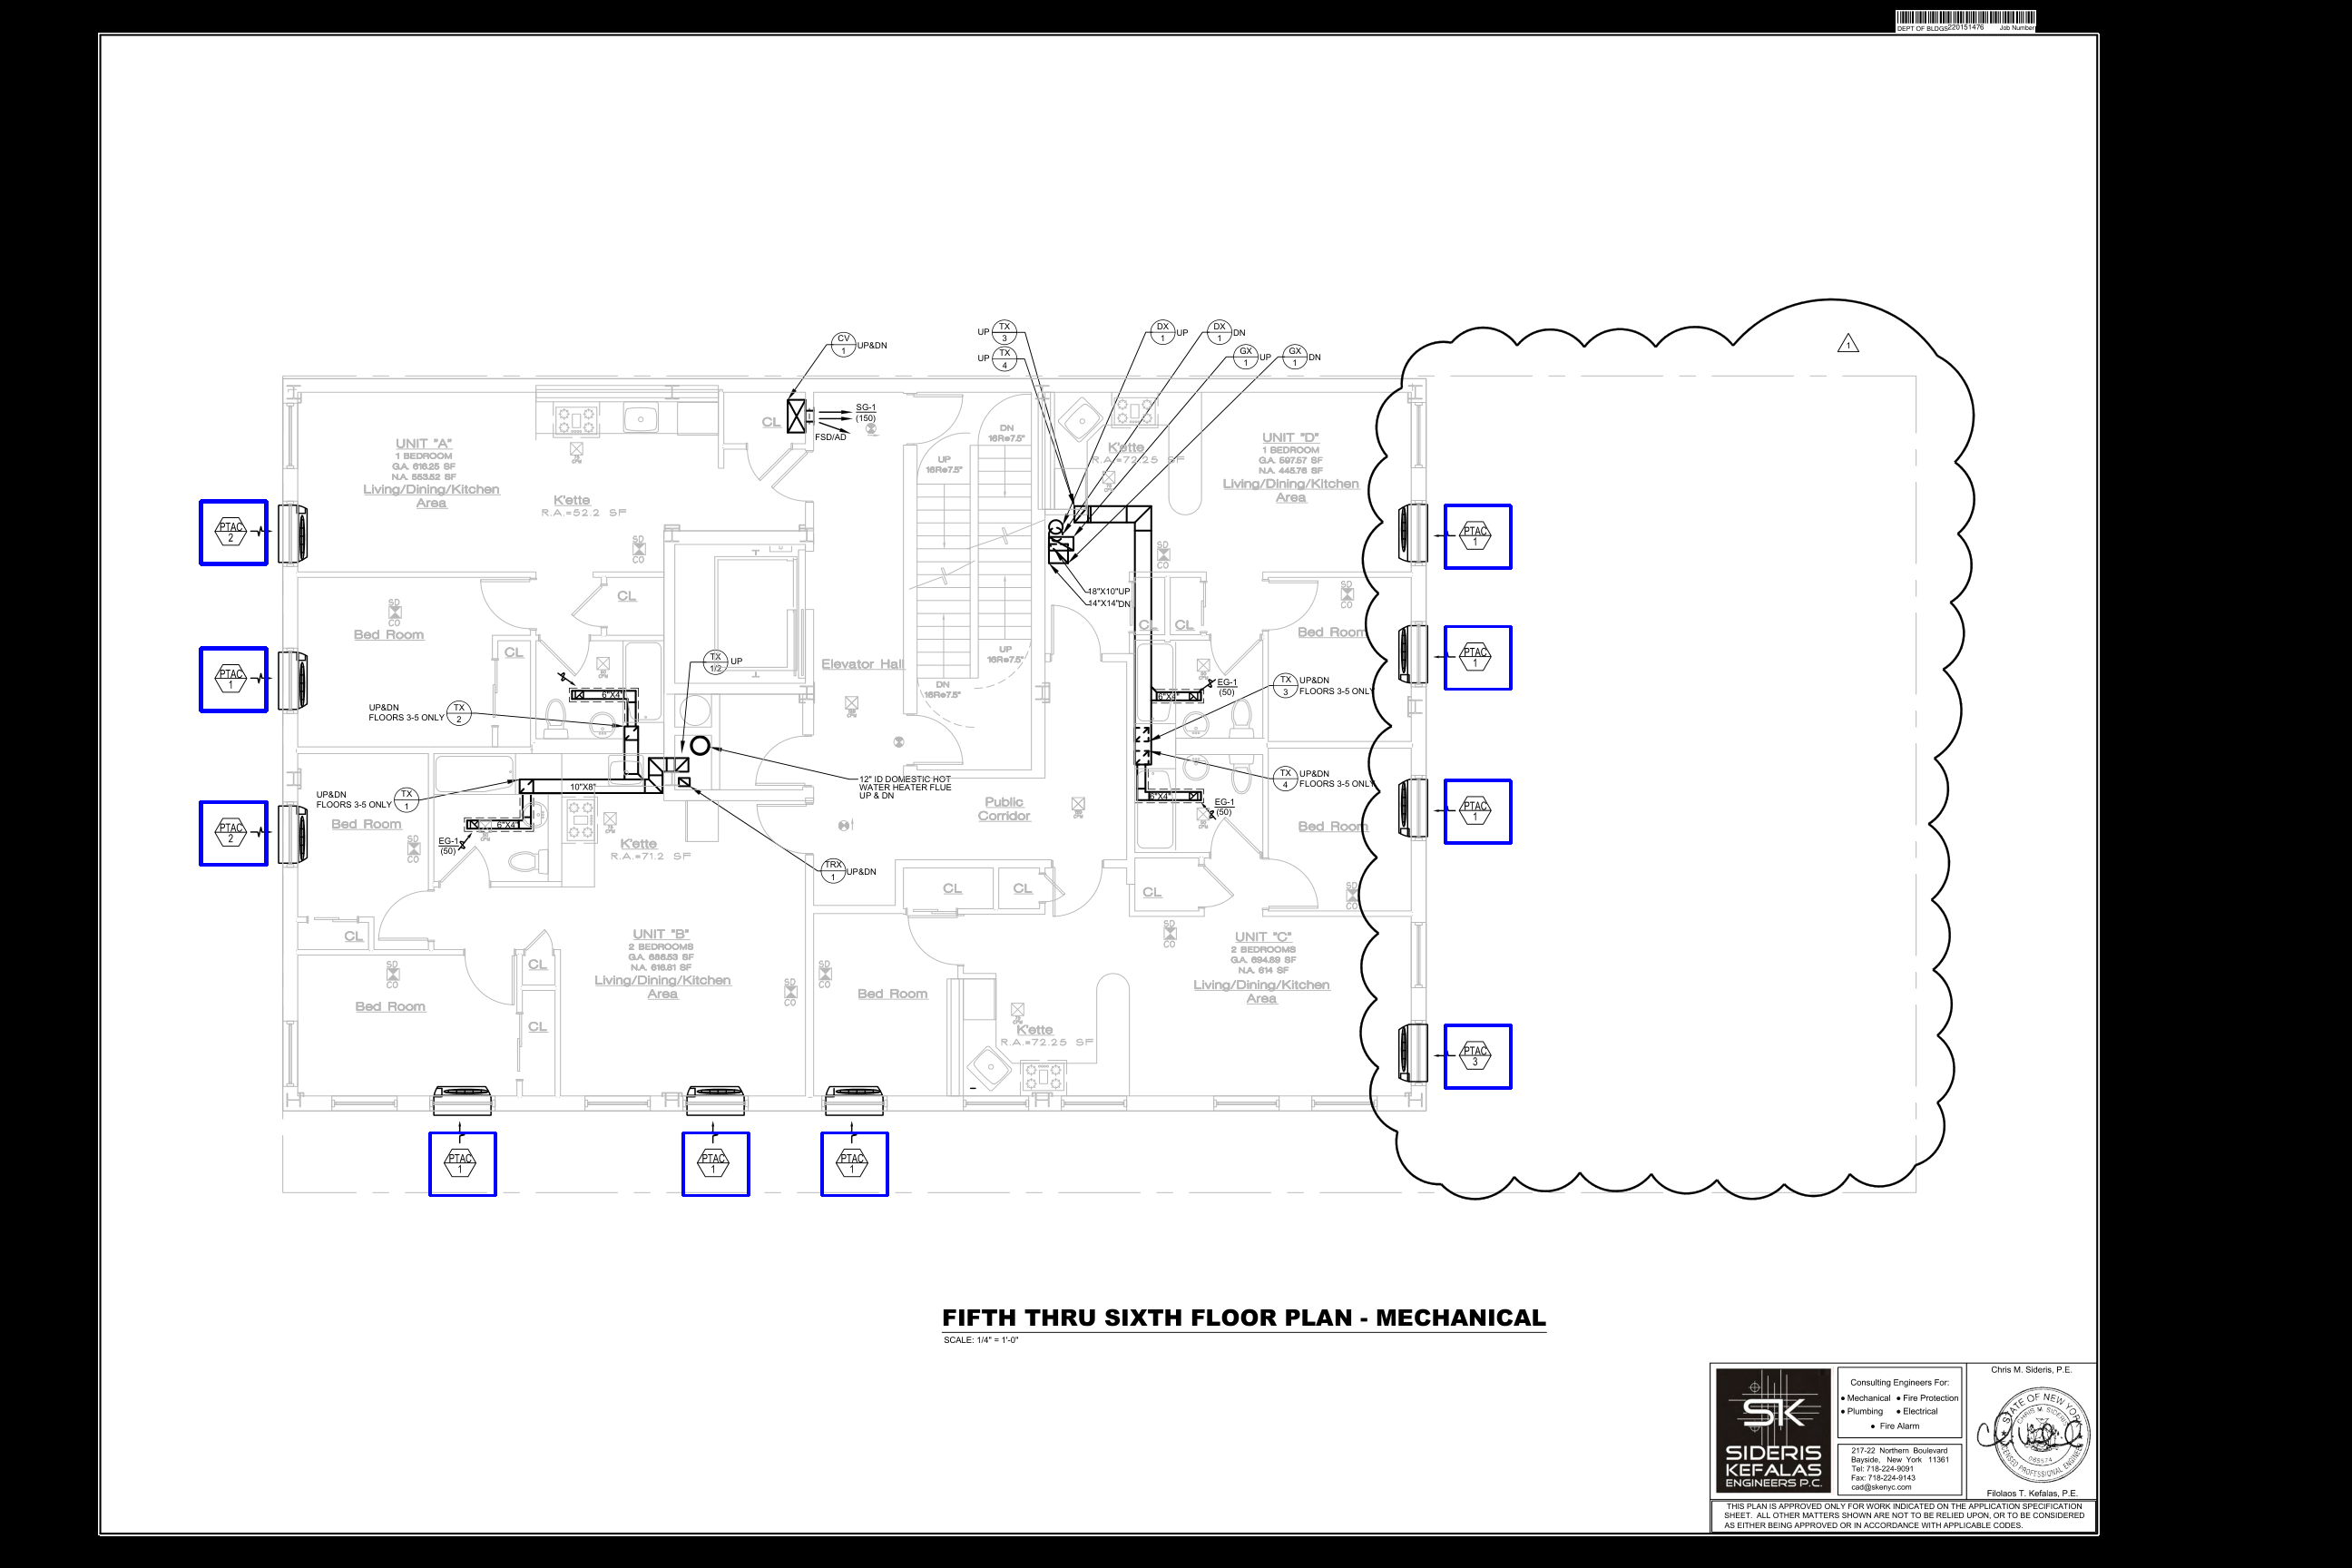

In [ ]:
def mechanical_feature_detector(image):
    """
    Detects mechanical features in a given floor plan image using multiple templates for each feature.

    Args:
    image: Grayscale image of the floor plan where features need to be detected.

    Returns:
    image: The original image with detected features highlighted.
    """

    def match_and_draw(image, templates, threshold, color):
        """
        Helper function to perform template matching and draw rectangles for all templates in a list.

        Args:
        image: The floor plan image to search within.
        templates: List of paths to template images.
        threshold: Matching threshold.
        color: Color to draw the rectangle around detected features.
        """
        # Ensure the input image is grayscale
        if len(image.shape) == 3:
            image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
            image_gray = image

        for template_path in templates:
            # Read the template
            template = cv2.imread(template_path)
            if template is None:
                print(f"Failed to load template: {template_path}")
                continue

            # Convert the template to grayscale
            template_gray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)

            # Ensure the template and image are in the same data type
            if image_gray.dtype != template_gray.dtype:
                template_gray = template_gray.astype(image_gray.dtype)

            # Perform template matching
            result = cv2.matchTemplate(image_gray, template_gray, cv2.TM_CCOEFF_NORMED)

            # Locate points where the match exceeds the threshold
            loc = np.where(result >= threshold)

            # Dimensions of the template
            h, w = template_gray.shape[:2]

            # Draw rectangles around detected symbols
            for pt in zip(*loc[::-1]):  # Switch x and y coordinates
                cv2.rectangle(image, pt, (pt[0] + w, pt[1] + h), color, 2)

    #################### Supply Air Duct [GREEN LABEL] ####################
    supply_air_templates = [
        '/content/Supply Air Duct.png',
        '/content/Supply Air Duct_v2.png',
    ]
    match_and_draw(image, supply_air_templates, threshold=0.45, color=(0, 255, 0))

    ######################################################################
    #################### Return Air Duct [RED LABEL] ####################

    return_air_templates = [
        '/content/Return Air Duct.png',
        '/content/Return Air Duct_v2.png',
        '/content/Return Air Duct_v3.png',
    ]
    match_and_draw(image, return_air_templates, threshold=0.75, color=(0, 0, 255))

    ######################################################################
    #################### PTAC [BLUE LABEL] ####################

    ptac_templates = [
        '/content/1_PTAC_v2.png',
    ]
    match_and_draw(image, ptac_templates, threshold=0.50, color=(255, 0, 0))

    ######################################################################

    return image

detected_image = mechanical_feature_detector(masked_image)
cv2_imshow(detected_image)

# Reference System

At least for now since I've been working with them, mechanical and plumbing have the same scale of 1/4 inch = 1 foot.

What is the proper way to create conversion scale? Should you consider pixels if there is no alternative?